In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_3DLorenz.recursive_LSTM_PostMeanScore_3DLorenz_T256_H05_tl_110data import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
num_paths = 10952

In [13]:
def get_drift_files(config):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    global_files = []
    true_files = []
    local_files = []
    for file in os.listdir(root_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file:
            if "global" in file:
                global_files.append(root_dir+file)
            elif "true" in file:
                true_files.append(root_dir+file)
            elif "local" in file:
                local_files.append(root_dir+file)
    assert len(global_files)>0, "No global files found"
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(global_files) == len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    global_files = sorted(global_files, key=extract_bw_number)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in global_files]
    return global_files, true_files, local_files, bws

In [14]:
config = get_config()
_, true_files, local_files, bws = get_drift_files(config=config)
local_files

['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f3DLnz_DriftTrack_00001bw_10952NPaths_00t0_3906e-03dT_27e+00Beta_28e+00Rho_10e+00Sigma_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f3DLnz_DriftTrack_0000126bw_10952NPaths_00t0_3906e-03dT_27e+00Beta_28e+00Rho_10e+00Sigma_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f3DLnz_DriftTrack_000012626472909607102bw_10952NPaths_00t0_3906e-03dT_27e+00Beta_28e+00Rho_10e+00Sigma_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f3DLnz_DriftTrack_0000159bw_10952NPaths_00t0_3906e-03dT_27e+00Beta_28e+00Rho_10e+00Sigma_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f3DLnz_DriftTrack_000015942781813704202bw_10952NPaths_00t0_3906e-03dT_27e+00Beta_28e+00Rho_10e+00Sigma_local_states.npy',
 '/Users/

0.09182735530413494 0.0 inf 0


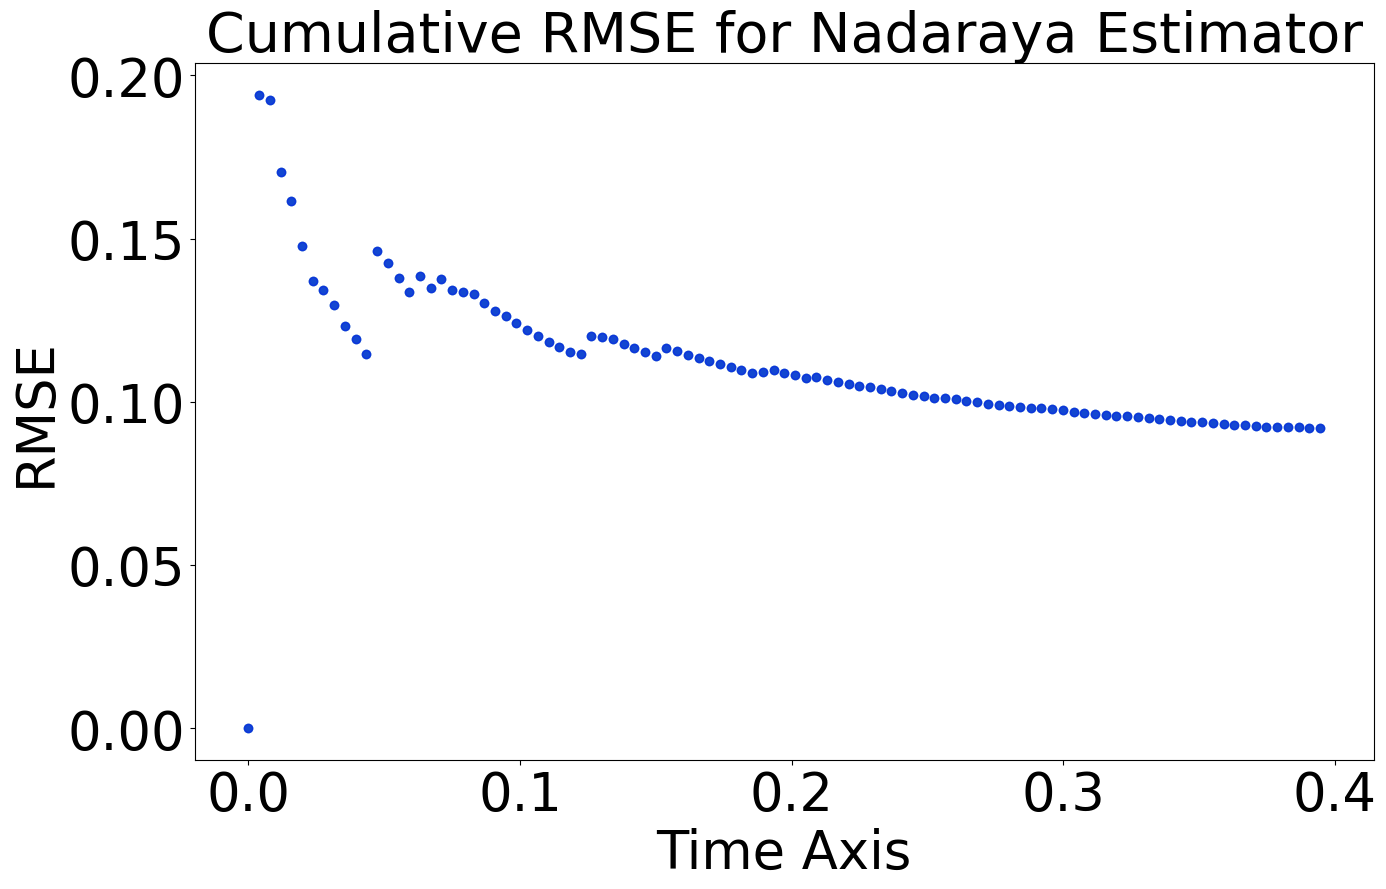

Final time cumulative RMSE local-time error 0.09182735530413494 with IQR (0.09182735530413498, 0.09182735530413498) at bw 1e-05

0.09986908198751741 0.0 0.09182735530413494 1
0.10393344559199251 0.0 0.09182735530413494 2
0.11720082229343416 0.0 0.09182735530413494 3
0.12981636961131765 0.0 0.09182735530413494 4
0.13977899018852735 0.0 0.09182735530413494 5
0.15424902596344475 0.0 0.09182735530413494 6
0.16802993832906385 0.0 0.09182735530413494 7
0.17659778148452696 0.0 0.09182735530413494 8
0.18641885730727334 0.0 0.09182735530413494 9
0.19678569627162196 0.0 0.09182735530413494 10
0.20475160402657303 0.0 0.09182735530413494 11
0.2089987768009954 0.0 0.09182735530413494 12
0.21533155612036387 0.0 0.09182735530413494 13
0.22516724971053118 0.0 0.09182735530413494 14
0.23028587056907898 0.0 0.09182735530413494 15
0.23235841499150842 0.0 0.09182735530413494 16
0.2398882444877692 0.0 0.09182735530413494 17
0.24524634052277333 0.0 0.09182735530413494 18
0.24323446176614957 0.0 0.0918273553

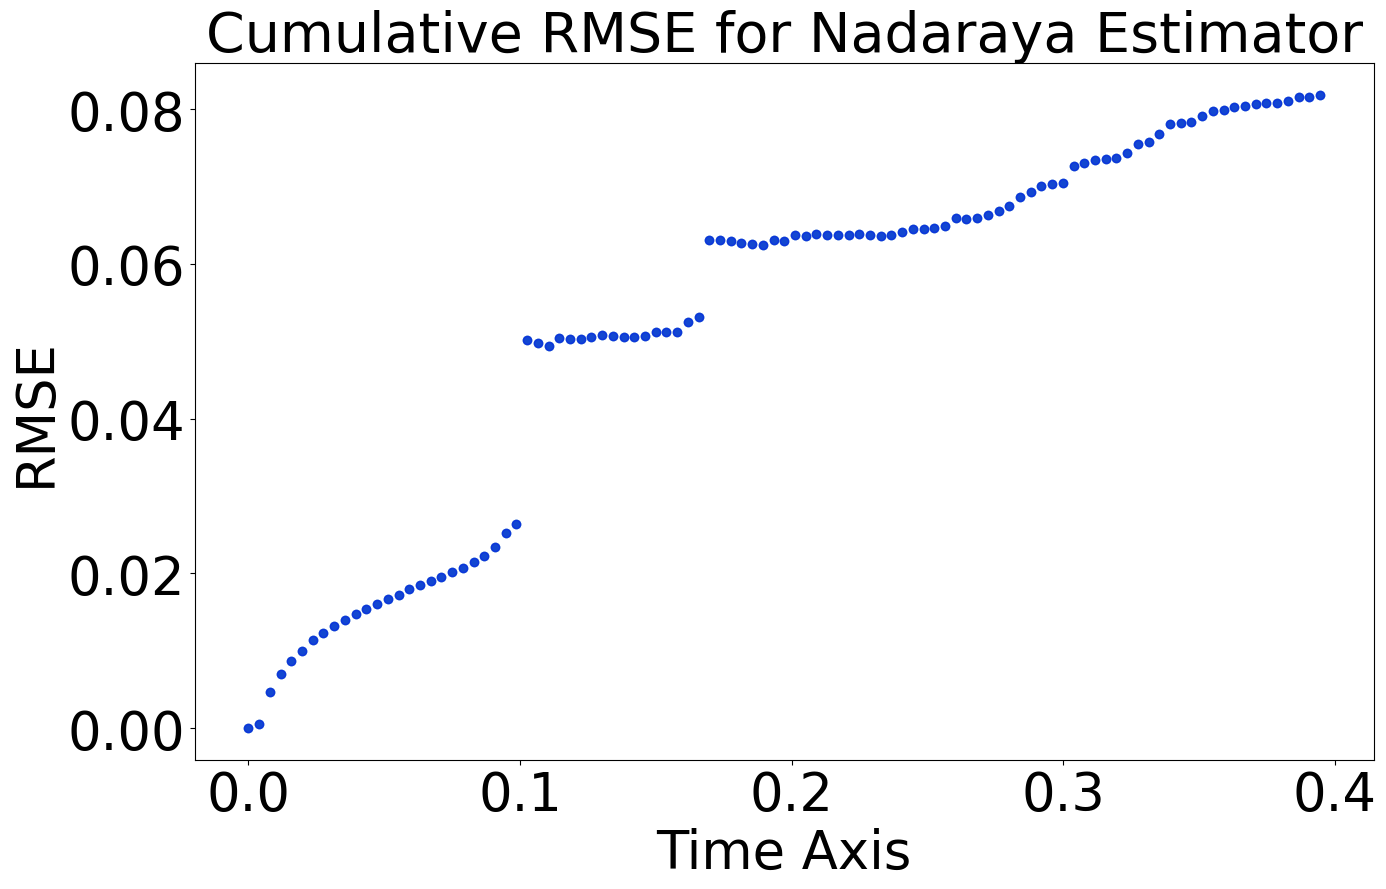

Final time cumulative RMSE local-time error 0.0818919118110209 with IQR (0.08189191181102091, 0.08189191181102091) at bw 0.0042987

0.059327602290915805 0.0 0.0818919118110209 27


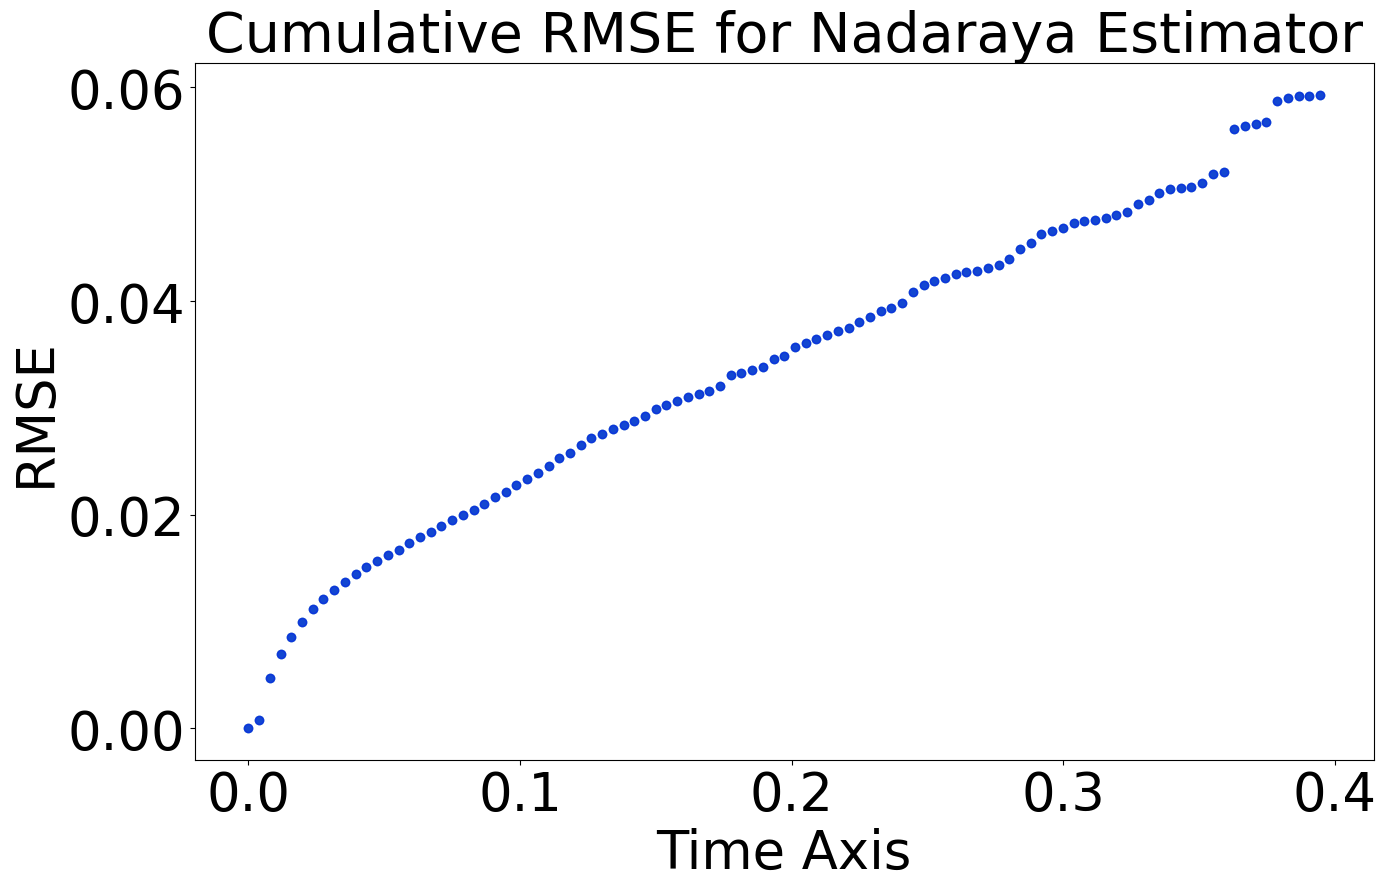

Final time cumulative RMSE local-time error 0.059327602290915805 with IQR (0.05932760229091582, 0.05932760229091582) at bw 0.0054277

0.047028963336805514 0.0 0.059327602290915805 28


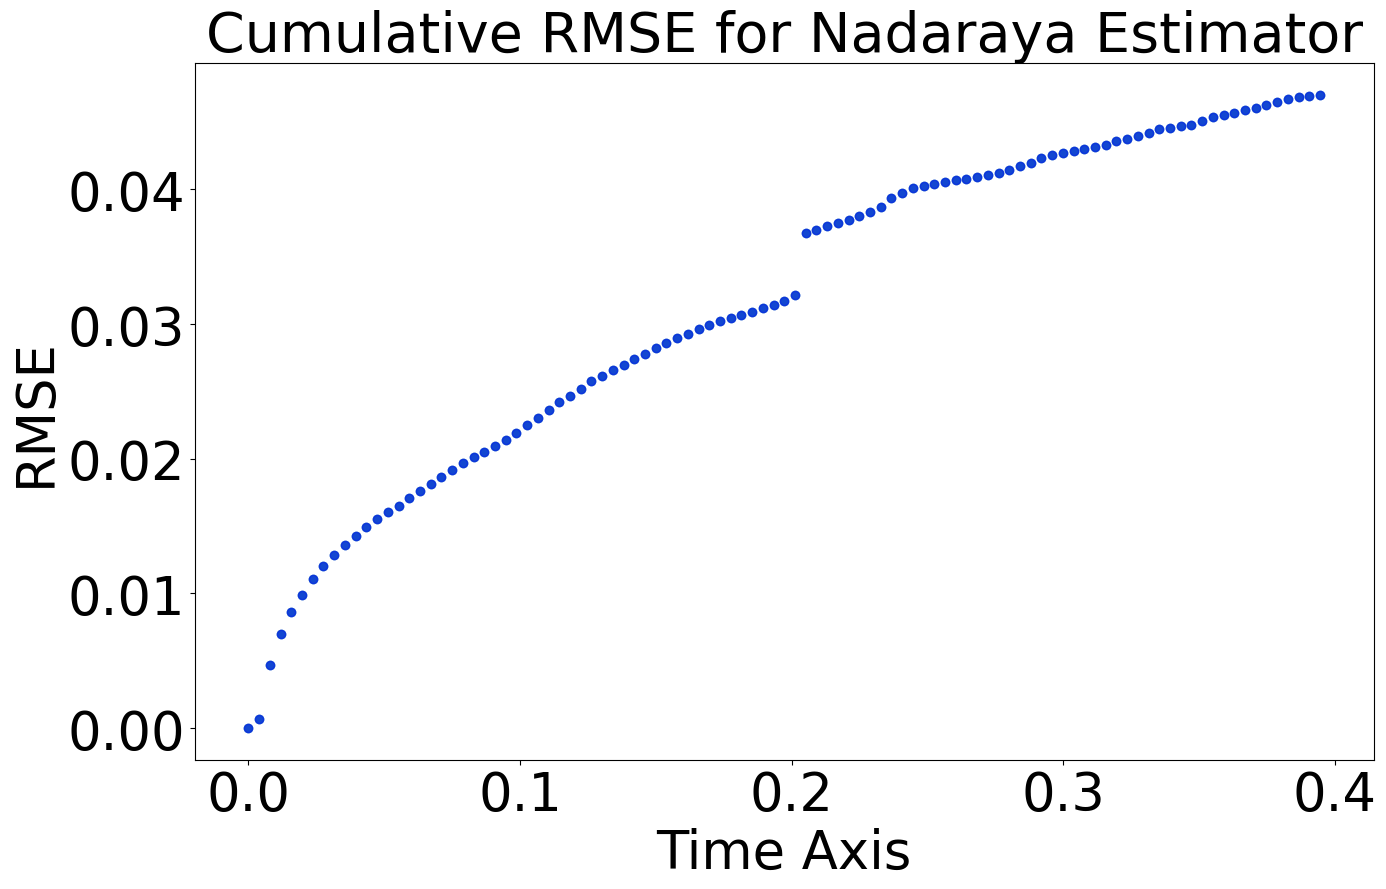

Final time cumulative RMSE local-time error 0.047028963336805514 with IQR (0.04702896333680553, 0.04702896333680553) at bw 0.0068533

0.04200517327182928 0.0 0.047028963336805514 29


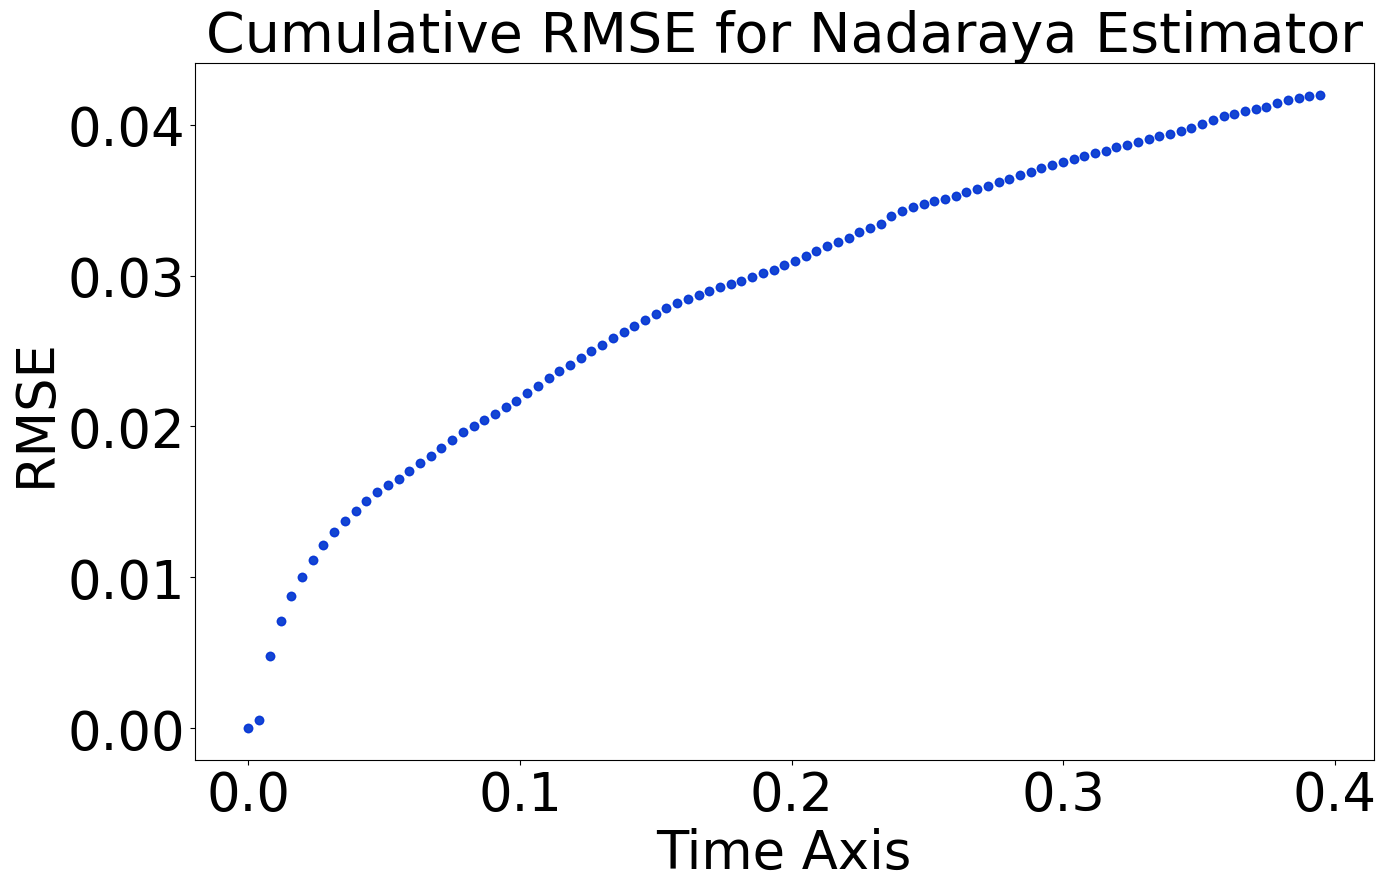

Final time cumulative RMSE local-time error 0.04200517327182928 with IQR (0.04200517327182928, 0.04200517327182928) at bw 0.0086533

0.03580107342599292 0.0 0.04200517327182928 30


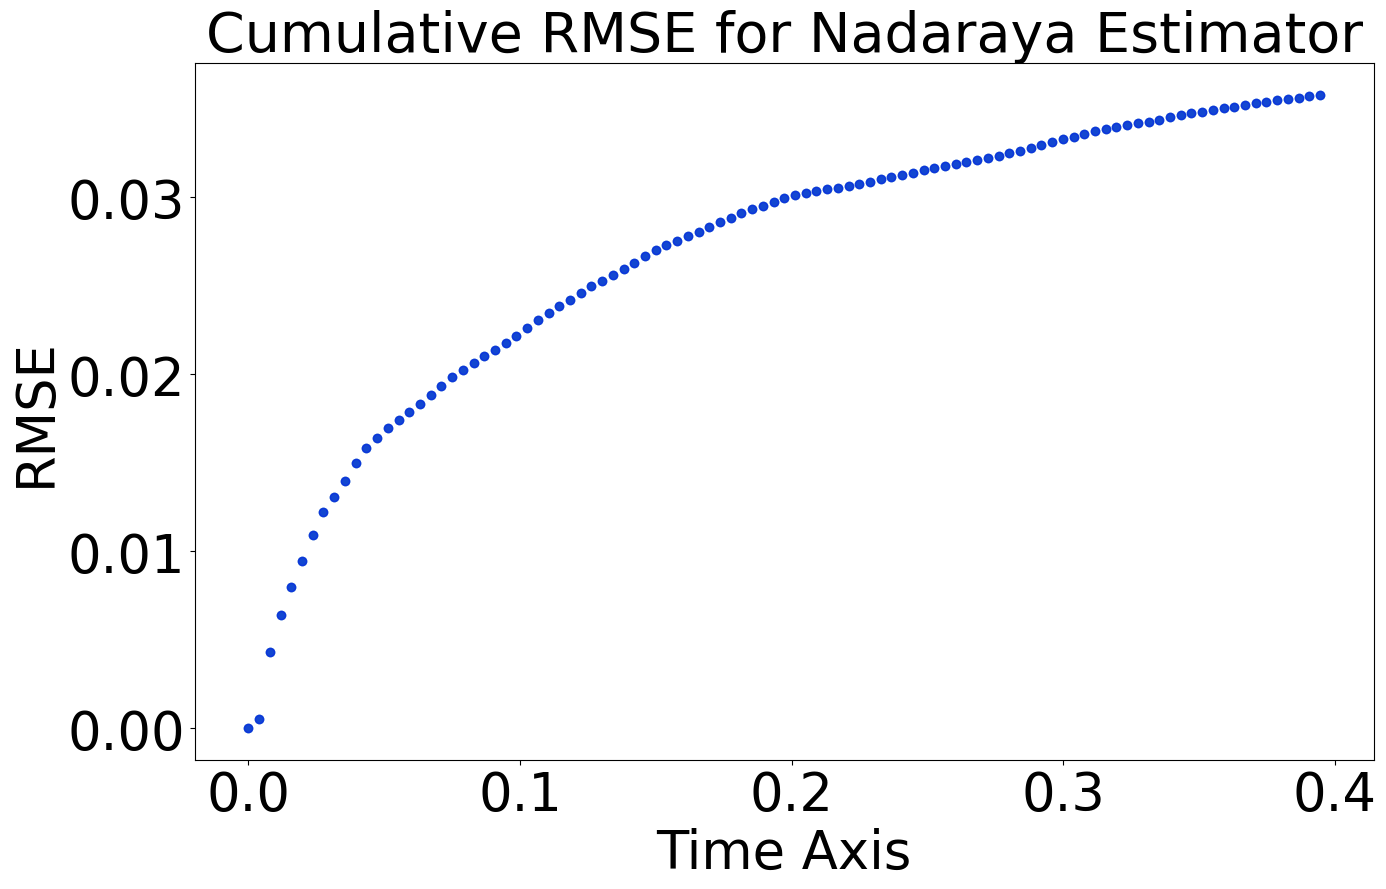

Final time cumulative RMSE local-time error 0.03580107342599292 with IQR (0.03580107342599292, 0.03580107342599292) at bw 0.010926

0.03600271532245943 0.0 0.03580107342599292 31
0.03694790640505366 0.0 0.03580107342599292 32
0.03834367950022236 0.0 0.03580107342599292 33
0.039862539793850384 0.0 0.03580107342599292 34
0.041216869336131993 0.0 0.03580107342599292 35
0.04233202912507025 0.0 0.03580107342599292 36
0.04324250744472183 0.0 0.03580107342599292 37
0.044021403232558196 0.0 0.03580107342599292 38
0.044736677703070854 0.0 0.03580107342599292 39


In [15]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])/np.sqrt(config.deltaT)
    all_local_states = np.load(file[1])/np.sqrt(config.deltaT)
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_rmse, i)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            miny = total_local_errors-total_local_errors_minq
            miny[miny < 0.] = 0.
            maxy = total_local_errors_maxq-total_local_errors
            maxy[maxy < 0.] = 0.
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
            plt.errorbar(time_steps,total_local_errors,yerr=[miny, maxy],xerr=None, fmt='o', color="blue", alpha=0.4)
            ax.set_title(f"Cumulative RMSE for Nadaraya Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/IIDNadaraya_DriftTrack_3DLnz_{round(bw, 6)}bw").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} with IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at bw {bw}\n")